In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from __future__ import division
import seaborn as sns

%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18.5, 10.5

from statsmodels.regression.mixed_linear_model import MixedLM

In [2]:
def print_resids(preds, resids):
    ax = sns.regplot(preds, resids);
    ax.set(xlabel = 'Predicted values', ylabel = 'errors', title = 'Predicted values vs. Errors')
    plt.show();

# Panel Data Analysis

## Question 1

The minimum wage policy in the paper raises the minimum wage in the state of New Jersey from \$4.25 to \$5.05. The researchers followed 410 stores in Pennsylvania and New Jersery before the rise in minimum wage in early 1992, and after the rise 7-8 months later. Almost 100 percent of the stores from the first wave of interviews continued on with the survery. They take in to account closing stores and employement changes, therefore they can measure the overall effect of the rise in minimum wage of unemployment.   

## Question 2

Estimate a Pooled OLS regression. The model I specify is:

$$ FTE = \beta_0 + \beta_1 year + + \beta_2 state  + \beta_3 state*year + \beta_4 GAP + \beta_5 price\_full\_meal + \epsilon $$

I will change year so that it is a binary variable. This way, the coefficient on it will be marginal effect of the minimum wage law on full time employment equivalent. As stated in the paper, the region experienced a small recession between 1991 and 1993, so I expect this to negatively affect FTE. I also expect the coefficient on state to be negative because of the greater mean number of employees in PA. As for the state \* year interaction, which gives the marginal effect of being in NJ after the wage hike, I also expect it to have a positive effect on employment.

The wage gap (GAP) is the proportional increase in wages at store i necessary to meet the new minimum rate. The reason I include this variable as a control is that if a store has to relatively increase wages a lot, then the costs of employment rise, thereby affecting how many employees that that store can have. I expect that this will have a negative effect on FTE. The price of a full meal includes a drink, small fries and an entree. I expect that the price of a meal is not strongly tied to how many employees work at that store. However, if sales stay the same after the wage hike, then stores with higher prices may be able to better sustain their workforce. Therefore, I expect a negative correlation with FTE.

In [3]:
min_wage = pd.read_stata('http://rlhick.people.wm.edu/econ407/data/Card_Kreuger_long.dta')

In [4]:
min_wage.head()

,sheet,year,chain,co_owned,state,southj,centralj,northj,pa1,pa2,...,hrsopen,psoda,pfry,pentree,nregs,nregs11,firstinc,bonus,pctaff,open
0,1,1,1,0,1,0,1,0,0,0,...,16.0,0.93,0.83,0.85,4.0,3.0,0.25,0.0,80.0,7.0
1,1,2,1,0,1,0,1,0,0,0,...,16.0,1.05,0.79,0.90,4.0,3.0,NaN,NaN,NaN,NaN
2,2,1,1,0,1,0,1,0,0,0,...,14.0,1.06,0.91,0.96,2.0,2.0,0.50,1.0,80.0,7.0
3,2,2,1,0,1,0,1,0,0,0,...,15.0,1.05,1.01,0.94,2.0,2.0,NaN,NaN,NaN,NaN
4,3,1,2,0,1,0,1,0,0,0,...,10.0,1.06,0.95,3.09,5.0,3.0,0.25,1.0,50.0,11.0


In [5]:
#min_wage = pd.read_stata('http://rlhick.people.wm.edu/econ407/data/Card_Kreuger_wide.dta')

In [6]:
min_wage.columns.values

array(['sheet', 'year', 'chain', 'co_owned', 'state', 'southj', 'centralj',
       'northj', 'pa1', 'pa2', 'shore', 'ncalls1', 'type2', 'status2',
       'date2', 'ncalls2', 'empft', 'emppt', 'nmgrs', 'wage_st', 'inctime',
       'firstin2', 'special2', 'meals', 'open2r', 'hrsopen', 'psoda',
       'pfry', 'pentree', 'nregs', 'nregs11', 'firstinc', 'bonus',
       'pctaff', 'open'], dtype=object)

I create a variable "FET" that is full time equivalent employment. it is # full time workers + 0.5 * part time workers. I also get the price of a full meal, which is the sum of the prices of a drink, small fry and entree.

In [7]:
min_wage['FTE'] = min_wage.empft + 0.5 * min_wage.emppt
# min_wage['FTE1'] = min_wage.empft1 + 0.5 * min_wage.emppt1 #T = 1 FTE
# min_wage['FTE2'] = min_wage.empft2 + 0.5 * min_wage.emppt2 #T = 2 FTE
# min_wage['price_full_meal1'] = min_wage['psoda1'] +  min_wage['pfry1'] +  min_wage['pentree1']
# min_wage['price_full_meal2'] = min_wage['psoda2'] +  min_wage['pfry2'] +  min_wage['pentree2']


GAP, is the proportional increase in wages at store i necessary to meet the new minimum rate. It only applies to stores located in NJ. Convert year to binary variable and get price of a full meal

In [8]:
def get_GAP(row):
    if (row[0] == 0) or (row[0] == 1 and row[1] >= 5.05):
        return 0
    else:
        return (5.05 - row[1]) / row[1]
def year_to_binary(x):
    if x == 1:
        return 0
    else:
        return 1
    
min_wage['GAP'] = min_wage[['state', 'wage_st']].apply(get_GAP, axis = 1)
min_wage['year'] = min_wage.year.apply(year_to_binary)
min_wage['price_full_meal'] = min_wage.psoda + min_wage.pfry + min_wage.pentree
min_wage['state_year'] = min_wage.state * min_wage.year

Examine the distribution of FTE, praying for normality

count    801.000000
mean      17.594570
std        9.022515
min        0.000000
25%       11.500000
50%       16.500000
75%       22.000000
max       80.000000
Name: FTE, dtype: float64

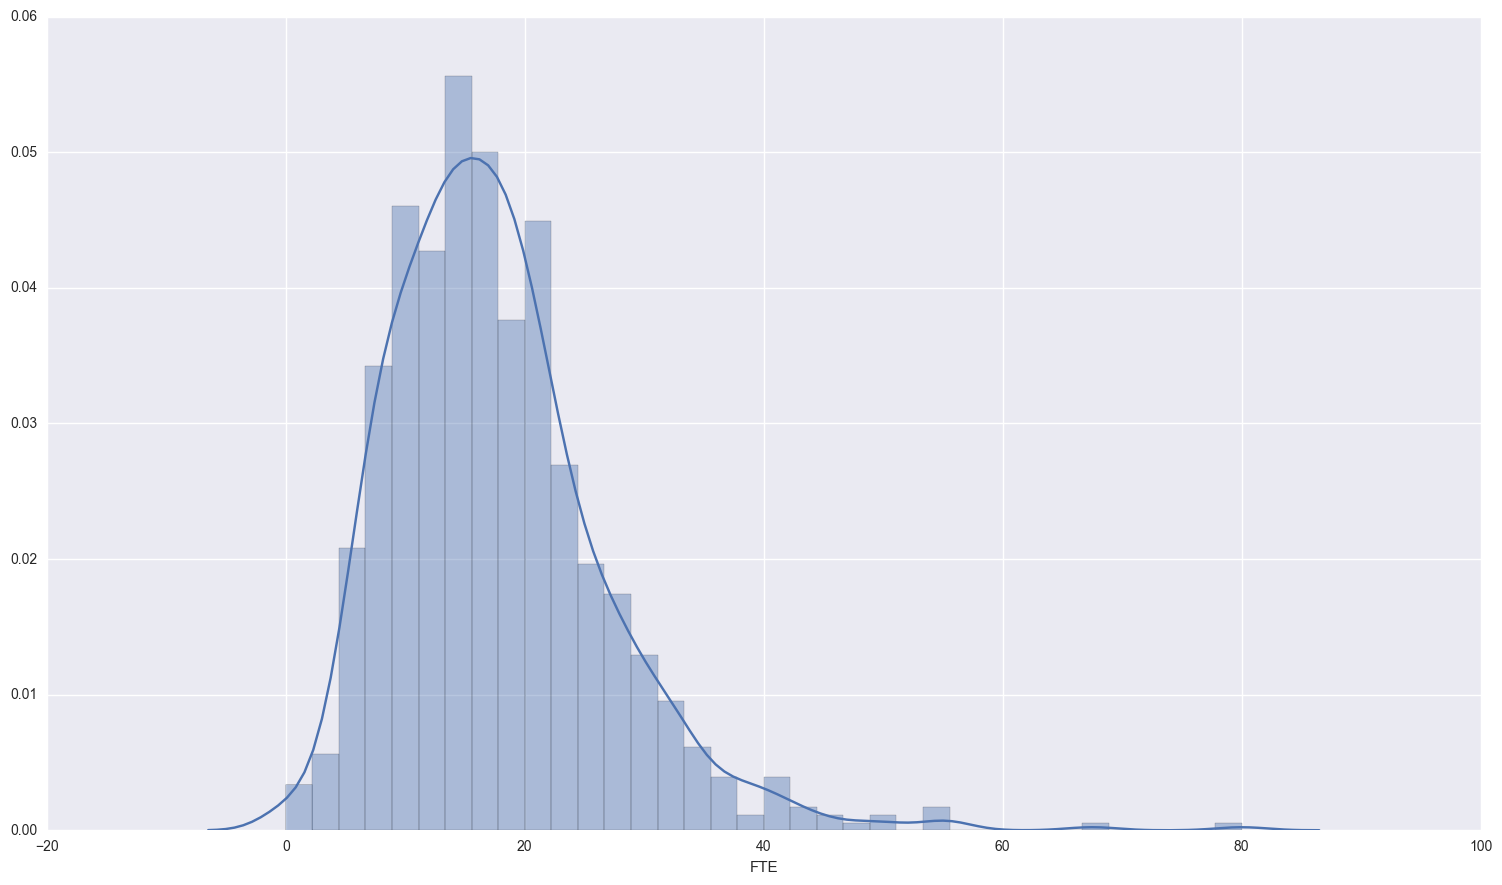

In [9]:
sns.distplot(min_wage[min_wage.FTE.notnull()]['FTE']); min_wage.FTE.describe()

So FTE is pretty normal, if a bit skewed left. There are also a couple of large values. Next we add a constant on and run the regression, dropping any observations that contain missin values.

In [10]:
pooled_ols_results = sm.OLS(min_wage['FTE'], 
                            sm.add_constant(min_wage[['year', 'state', 'state_year', 'GAP', 'price_full_meal']]), 
                            missing = 'drop').fit()

pooled_ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     27.58
Date:                Sun, 30 Oct 2016   Prob (F-statistic):           1.28e-25
Time:                        22:20:55   Log-Likelihood:                -2550.9
No. Observations:                 733   AIC:                             5114.
Df Residuals:                     727   BIC:                             5141.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const              35.5014      1.669     21.268      0.000        32.224    38.779
year               -2.1313      1.311     -1.626      0.104        -4.705     0.442
state              -0.3041      1.239     -0.245      0.806        -2.737     2.129
state_year          2.2260      1.615      1.378      0.169        -0.945     5.397
GAP               -11.9613      6.461     -1.851      0.065       -24.647     0.724
price_full_meal    -5.1294      0.459    -11.167      0.000        -6.031    -4.228
==============================================================================
Omnibus:                      227.946   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              786.038
Skew:                           1.462   Prob(JB):                    2.06e-171
Kurtosis:                       7.146   Cond. No.                         82.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

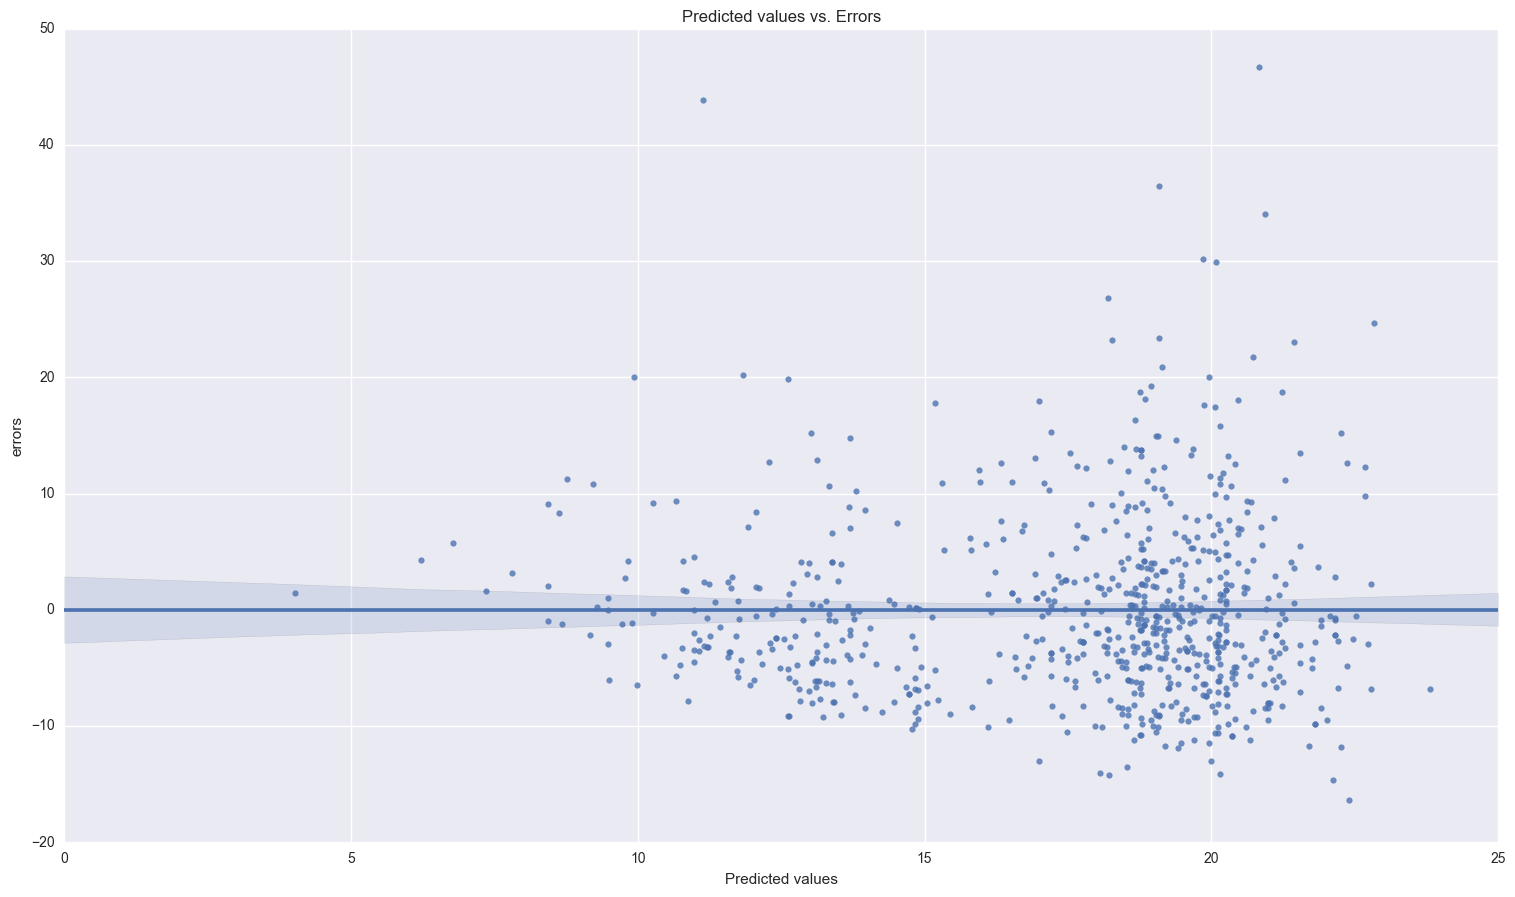

In [11]:
print_resids(pooled_ols_results.predict(), pooled_ols_results.resid)

The marginal effect on employment with respect to the new minimum wage policy is positive. On average, there were 2.226 more full time equivalent employees after the wage hike in NJ.

## Question 3

Estimate a random effects model. I will estimate a random intercept for each state.


In [41]:
no_nulls = min_wage[['FTE','year', 'state', 'state_year', 'GAP', 'price_full_meal']].dropna()
re_results = MixedLM(no_nulls['FTE'], sm.add_constant(no_nulls[['state', 'state_year', 'GAP', 'price_full_meal']]), 
            groups = no_nulls['year'], missing = 'drop').fit()
# re_results = MixedLM.from_formula("FTE ~ year + state_year + GAP + price_full_meal", data = no_nulls, 
#                                   groups = no_nulls.state, missing = 'drop')

In [42]:
re_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  FTE       
No. Observations:    733      Method:              REML      
No. Groups:          2        Scale:               62.2025   
Min. group size:     366      Likelihood:          -2548.1518
Max. group size:     367      Converged:           Yes       
Mean group size:     366.5                                   
-------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
-------------------------------------------------------------
const            34.422    1.756  19.606 0.000  30.981 37.863
state             0.108    1.098   0.098 0.922  -2.045  2.260
state_year        1.398    1.091   1.281 0.200  -0.740  3.535
GAP             -12.156    6.461  -1.881 0.060 -24.820  0.508
price_full_meal  -5.123    0.459 -11.153 0.000  -6.023 -4.223
Intercept RE      1.411                                      
=============================================================

"""

In [31]:
from statsmodels.stats.diagnostic import het_breushpagan

resids = re_results.predict() - no_nulls['FTE']

het_breushpagan(resids,no_nulls[['year', 'state_year', 'GAP', 'price_full_meal']] )

NotImplementedError: 

In [40]:
print sm.show_versions()



INSTALLED VERSIONS
------------------
Python: 2.7.12.final.0
OS: Darwin 15.6.0 Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64 x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8

Statsmodels

Installed: 0.6.1 (//anaconda/lib/python2.7/site-packages/statsmodels)

Required Dependencies

cython: 0.24.1 (//anaconda/lib/python2.7/site-packages/Cython)
numpy: 1.11.2 (//anaconda/lib/python2.7/site-packages/numpy)
scipy: 0.18.1 (//anaconda/lib/python2.7/site-packages/scipy)
pandas: Cannot detect version (//anaconda/lib/python2.7/site-packages/pandas)
    dateutil: 2.5.3 (//anaconda/lib/python2.7/site-packages/dateutil)
patsy: 0.4.1 (//anaconda/lib/python2.7/site-packages/patsy)

Optional Dependencies

matplotlib: 1.5.1 (//anaconda/lib/python2.7/site-packages/matplotlib)
cvxopt: Not installed

Developer Tools

IPython: 5.1.0 (//anaconda/lib/python2.7/site-packages/IPython)
    jinja2: 2.8 (//anaconda/lib/python2.7/site-packages/jinja2)
sphi

First, I need to specify time invariant variables, and then the ones that change over each time period. The ones that change, I take the difference between the two time periods. For those differenced variables, I create a new differenced dataframe.

In [ ]:
time_invar = ['sheet', 'chain', 'co_owned', 'state', 'southj', 'centralj',
       'northj', 'pa1', 'pa2', 'shore', 'GAP', 'pctaff1']
t1_vars = ['ncalls1', 'empft1', 'emppt1','nmgrs1', 'wage_st1', 'inctime1', 'firstinc1',  
           'open1', 'hrsopen1', 'psoda1', 'pfry1', 'pentree1', 'nregs1', 'nregs111', 
           'FTE1', 'price_full_meal1']

t2_vars = ['ncalls2','empft2', 'emppt2', 'nmgrs2', 'wage_st2', 'inctime2', 'firstin2',
           'open2r', 'hrsopen2', 'psoda2', 'pfry2', 'pentree2', 'nregs2', 'nregs112', 
           'FTE2', 'price_full_meal2']

len(t1_vars), len(t2_vars)

In [ ]:
diff_wage = pd.DataFrame()
for i in xrange(len(t1_vars)):
    label = t1_vars[i][:-1] + '_diff'
    diff_wage[label] = min_wage[t2_vars[i]] - min_wage[t1_vars[i]]

In [ ]:
diff_wage.head()

Now that I have the differenced variables, add back our time invariant variables so that we can control for location etc.

In [ ]:
diff_wage = diff_wage.join(min_wage[time_invar])

In [ ]:
diff_wage.columns.values

## Question 2

The model specification I will use is:

$$ \Delta FTE_{it} = \beta_0 +  \beta_1 empft\_diff + \beta_2 emppt\_diff + \beta_3 firstinc\_diff + \beta4 hrsopen\_diff + \beta_5 price\_full\_meal\_diff + \beta_6 GAP + \epsilon$$



year will be our before/after variable, and state is control/treatment group. 1 indicates treatment (NJ)

The model that we will estimate is a Difference in Difference model:

$$ \Delta FTE_{it} = \beta_0 + \delta_0 year + \beta_1 State + \delta_1 ( year * state) + C_i + \epsilon_{it} $$

Where $\delta_1$ is the treatment effect of the wage hike

In [ ]:
min_wage['year_state'] = min_wage.year * min_wage.state
min_wage_constant = sm.add_constant(min_wage)

In [ ]:
min_wage_constant.head()

In [ ]:
sm.OLS(min_wage_constant['FTE'], min_wage_constant[['const', 'state']], missing = 'drop').fit().summary()

In [ ]:
sm.OLS(min_wage_constant['FTE'], min_wage_constant[['const', 'year', 'state', 'year_state']], missing = 'drop').fit().summary()

In [ ]:
control_before = min_wage[(min_wage.year == 1) & (min_wage.state == 0)] # PA, before wage hike
control_after = min_wage[(min_wage.year == 2) & (min_wage.state == 0)] #PA, after wage hike

treat_before = min_wage[(min_wage.year == 1) & (min_wage.state == 1)] #NJ, before wage hike
treat_after = min_wage[(min_wage.year == 2) & (min_wage.state == 1)] #